In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### 1) 데이터 불러오기 및 정리

In [3]:
# 자전거 데이터 캐글
# https://www.kaggle.com/c/bike-sharing-demand/overview

In [5]:
# 데이터 불러오기
bike_df = pd.read_csv('./data/bike_train.csv')
bike_df.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


해야 할 것)
1. casual + registered = count      
    => casual, registered 날리기 (중복되어 가중될 수 있다)
2. 연/월/일 별로 어떤 영향력이 있는지를 확인해보기          
    => datetime을 datetime타입으로 변환         
    -> 연/월/일/시간/요일 뽑아서 컬럼으로 만들고 datetime 지우기


In [8]:
# 데이터 확인
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


<Axes: xlabel='season', ylabel='Count'>

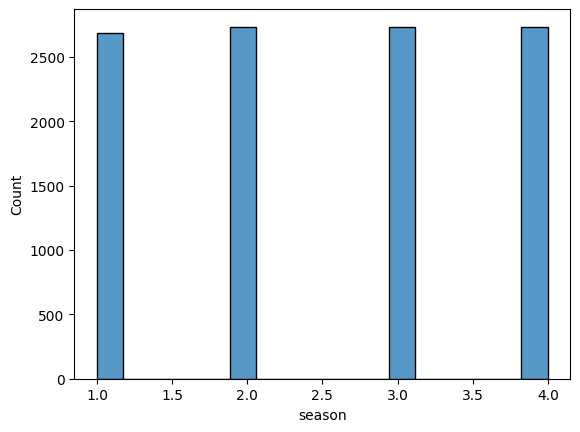

In [11]:
sns.histplot(bike_df['season'])

In [17]:
# 문자열을 datetime 타입으로 변경.
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
# 년 추출
bike_df['year'] = bike_df['datetime'].dt.year
# 월 추출
bike_df['month'] = bike_df['datetime'].dt.month
# 일 추출 
bike_df['day'] = bike_df['datetime'].dt.day
# 시간 추출
bike_df['hour'] = bike_df['datetime'].dt.hour
# 요일 추출
bike_df['dayofweek'] = bike_df['datetime'].dt.dayofweek # 0: 월요일
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,5


In [18]:
drop_columns = ['datetime','casual','registered']
# 필요없는 컬럼 삭제하기
bike_df.drop(drop_columns, axis=1, inplace=True)
bike_df.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour,dayofweek
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0,5
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1,5


### 2) EDA를 위한 시각화하기 - 조건에 따른 대여량 시각화

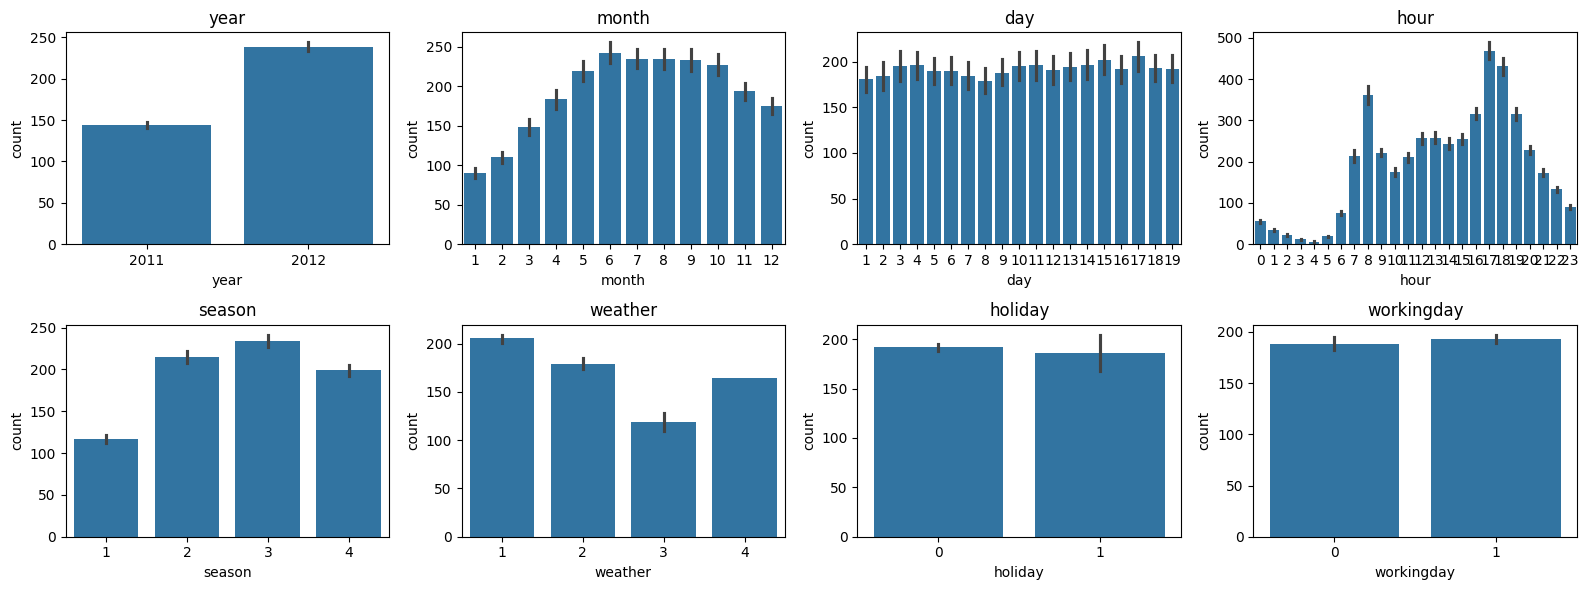

In [32]:
# TODO: 막대 그래프(년, 월, 시즌, 날씨, 일, 시간, 휴일, 근무일)
# 연, 월, 일, 시간 그래프
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(16, 6))

columns = ['year', 'month', 'day', 'hour','season','weather', 'holiday', 'workingday']
titles = ['year', 'month', 'day', 'hour','season','weather', 'holiday', 'workingday']

idx = 0

for row in range(2):
    for col in range(4):
        sns.barplot(data=bike_df, x=columns[idx], y='count', ax=ax[row, col])
        ax[row,col].set_title(titles[idx])
        idx += 1

plt.tight_layout()  # 그래프 간격 자동 조정
plt.show()

의미 도출 
* temp, atemp 중복 -> 그 중에 하나 제거 
* day도 위에서 봤을 때 큰 의미 없는 것 같으므로 제거

### 3) 모델 생성 및 학습

In [37]:
# 변수 선택
X = bike_df.drop(['count', 'temp', 'day'], axis=1)
y = bike_df['count']

In [ ]:
X.head(1)

,season,holiday,workingday,weather,atemp,humidity,windspeed,year,month,hour,dayofweek
0,1,0,0,1,14.395,81,0.0,2011,1,0,5


In [82]:
# 훈련세트/테스트세트 분할
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# 확인
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8708, 11) (2178, 11) (8708,) (2178,)


In [83]:
# 모델 생성 및 훈련
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)

# 모델 성능
from sklearn.metrics import mean_squared_error, r2_score
print(f'MSE: {mean_squared_error(y_test, pred):.2f}')
print(f'r2_score: {r2_score(y_test, pred):.2f}')

# 과적합 확인
print(f'train: {lr.score(X_train, y_train):.2f}')
print(f'test: {lr.score(X_test, y_test):.2f}')

MSE: 19963.45
r2_score: 0.40
train: 0.39
test: 0.40


### 3-1) KneighborRegressor 사용하기

In [84]:
# 모델 생성 및 훈련
from sklearn.neighbors import KNeighborsRegressor
knr = KNeighborsRegressor()
knr.fit(X_train, y_train)
pred = knr.predict(X_test)

# 모델 성능
from sklearn.metrics import mean_squared_error, r2_score
print(f'MSE: {mean_squared_error(y_test, pred):.2f}')
print(f'r2_score: {r2_score(y_test, pred):.2f}')

# 과적합 확인
print(f'train: {knr.score(X_train, y_train):.2f}')
print(f'test: {knr.score(X_test, y_test):.2f}')

MSE: 12962.71
r2_score: 0.61
train: 0.73
test: 0.61


모델만 바꿨는데도 0.40 -> 0.61 로 상승
but 조금 과적합

### 3-2) DecisionRegressor 사용하기

In [85]:
# 모델 생성 및 훈련
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
pred = dtr.predict(X_test)

# 모델 성능
from sklearn.metrics import mean_squared_error, r2_score
print(f'MSE: {mean_squared_error(y_test, pred):.2f}')
print(f'r2_score: {r2_score(y_test, pred):.2f}')

# 과적합 확인
print(f'train: {dtr.score(X_train, y_train):.2f}')
print(f'test: {dtr.score(X_test, y_test):.2f}')

MSE: 3585.38
r2_score: 0.89
train: 1.00
test: 0.89


r2_score 0.9로 급상승! 
과적합은 있지만 학습은 100% 상승

### 3-3) 앙상블 사용하기

In [86]:
# 모델 생성 및 훈련
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
pred = rfr.predict(X_test)

# 모델 성능
from sklearn.metrics import mean_squared_error, r2_score
print(f'MSE: {mean_squared_error(y_test, pred):.2f}')
print(f'r2_score: {r2_score(y_test, pred):.2f}')

# 과적합 확인
print(f'train: {rfr.score(X_train, y_train):.2f}')
print(f'test: {rfr.score(X_test, y_test):.2f}')

MSE: 1519.62
r2_score: 0.95
train: 0.99
test: 0.95


r2_score도 높고 과적합도 줄었음 

### 4) 성능을 높이기 위한 전처리

In [79]:
X_train.columns

Index(['season', 'holiday', 'workingday', 'weather', 'atemp', 'humidity',
       'windspeed', 'year', 'month', 'hour', 'dayofweek'],
      dtype='object')

현재 데이터의 문제
1. season, year, month, day, hour, dayofweek : 범주형 데이터 (숫자이지만) => 원핫인코딩 필요      
2. atemp, humidity, windspeed : 수치형 데이터 => 범위가 다르므로 스케일링이 필요

#### 4-1) 수치형변수 스케일링

<Axes: >

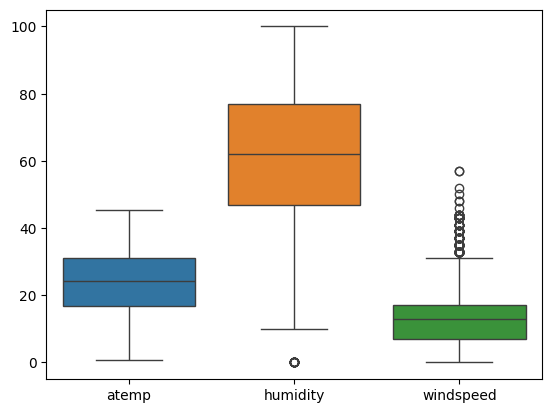

In [ ]:
# 수치형변수 스케일링 전 시각화
sns.boxplot(X_train[['atemp', 'humidity', 'windspeed']])

In [90]:
# 수치형 데이터에 대한 스케일링
from sklearn.preprocessing import StandardScaler

numerical_features = ['atemp', 'humidity', 'windspeed']
st_scaler = StandardScaler()

# 위 3가지 변수에 대해서만 스케일링
X_train_prep = X_train.copy()
X_train_prep[numerical_features] = st_scaler.fit_transform(X_train[numerical_features])

X_test_prep = X_test.copy()
X_test_prep[numerical_features] = st_scaler.transform(X_test[numerical_features])

<Axes: >

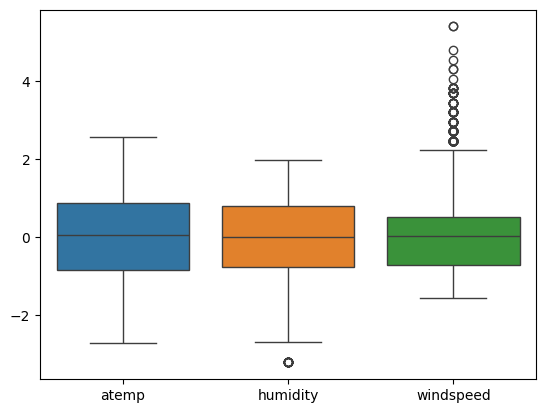

In [91]:
# 스케일링 후 시각화해서 확인
sns.boxplot(X_train_prep[['atemp', 'humidity', 'windspeed']])

#### 4-2) 범주형변수 원핫인코딩

In [92]:
# 원핫인코딩 전 시각화
categorical_features = ['season', 'weather', 'year', 'month', 'hour', 'dayofweek']
X_train[categorical_features].head(1)

,season,weather,year,month,hour,dayofweek
2815,3,1,2011,7,5,2


In [93]:
# 범주형변수 원핫인코딩 
from sklearn.preprocessing import OneHotEncoder


categorical_features = ['season', 'weather', 'year', 'month', 'hour', 'dayofweek']
oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# 원핫인코딩 시 생성되는 여러 개의 columns 생성
X_train_ohe = oh_encoder.fit_transform(X_train[categorical_features])
X_test_ohe = oh_encoder.transform(X_test[categorical_features])
## => onehotencoder는 각각 원핫인코딩 완료된 numpy 배열을 반환 

# 위 컬럼명을 바탕으로 원핫인코딩된 배열들의 컬럼 이름 생성해서 가져오기
ohe_feature_names = oh_encoder.get_feature_names_out(categorical_features) # season_1, season_2, ... 로 이루어진 numpy 배열

# 원핫인코딩 배열 + 각 컬럼 이름 으로 데이터프레임 생성(이따 수치형 변수 데이터랑 합치기 위해)
X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe_feature_names, index=X_train.index)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe_feature_names, index=X_test.index)

X_train_ohe.head(2) # 원래 컬럼은 사라지고 인코딩된 컬럼들만 남게됨

,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4,year_2011,year_2012,...,hour_21,hour_22,hour_23,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
2815,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8695,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [95]:
# 완성된 인코딩 컬럼들 합치기

# 전처리하지 않았던 나머지 column도 추가하기 위해 정의
remain_features = ['holiday', 'workingday']

# pd.concat( 합칠 객체들 리스트, axis= , join= , ignore_index=False(True면 재설정) )
X_train_prep = pd.concat([X_train_prep[numerical_features], X_train_ohe, X_train[remain_features]], axis=1) 
X_test_prep = pd.concat([X_test_prep[numerical_features], X_test_ohe, X_test[remain_features]], axis=1)

X_train_prep.head(2)

,atemp,humidity,windspeed,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,...,hour_23,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,holiday,workingday
2815,0.960505,1.098553,-0.828356,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1
8695,2.034991,-1.182694,0.878555,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0


### 5) 전처리 후 모델 생성 및 훈련

In [96]:
# 최종 훈련 테스트 데이터 만들어서 모델 생성 및 훈련
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train_prep, y_train)
pred = lr.predict(X_test_prep)

# 모델 성능
from sklearn.metrics import mean_squared_error, r2_score
print(f'MSE: {mean_squared_error(y_test, pred):.2f}')
print(f'r2_score: {r2_score(y_test, pred):.2f}')

# 과적합 확인
print(f'train: {lr.score(X_train_prep, y_train):.2f}')
print(f'test: {lr.score(X_test_prep, y_test):.2f}')

MSE: 10034.86
r2_score: 0.70
train: 0.69
test: 0.70


전처리 전)  
* MSE: 19963.45
* r2_score: *0.40*
* train: 0.39
* test: 0.40

전처리 후)  
* MSE: 10035.92
* r2_score: *0.70*
* train: 0.69
* test: 0.70

결과 비교)
* MSE : 19963 -> 10035    
* r2_score : 0.40 -> 0.70 (+0.3)  
* train : 0.39 -> 0.69 (+0.3)
* test : 0.40 -> 0.70 (+0.3)

=> 범주형 변수들을 원핫인코딩, 수치형 변수들을 표준화하니 변수들을 더 잘 반영하게 된 듯

### 6) 새로운 데이터로 예측해보기

In [98]:
# 새로운 데이터 예측 하기 

new_row = {
    "season": 2, "holiday": 0, "workingday": 1, "weather": 1,
    "atemp": 20.5, "humidity": 55, "windspeed": 0.12,
    "year": 2025, "month": 5, "day": 1, "hour": 17, "dayofweek": 3
}

new_df = pd.DataFrame([new_row])
new_df

,season,holiday,workingday,weather,atemp,humidity,windspeed,year,month,day,hour,dayofweek
0,2,0,1,1,20.5,55,0.12,2025,5,1,17,3


In [104]:
# 범주형 변수 - 원핫인코딩
new_ohe = oh_encoder.transform(new_df[categorical_features])
new_ohe_columns_names = oh_encoder.get_feature_names_out(categorical_features)
new_df_ohe = pd.DataFrame(new_ohe, columns=new_ohe_columns_names, index=new_df.index)
new_df_ohe

,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4,year_2011,year_2012,...,hour_21,hour_22,hour_23,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [105]:
# 수치형 변수 - 스케일링
new_df[numerical_features] = st_scaler.transform(new_df[numerical_features])
new_df[numerical_features]

,atemp,humidity,windspeed
0,-0.377578,-0.353149,-1.545838


In [107]:
# 전처리한 컬럼들 합치기
new_df = pd.concat([new_df[numerical_features], new_df_ohe, new_df[remain_features]], axis=1)
new_df.columns

Index(['atemp', 'humidity', 'windspeed', 'season_1', 'season_2', 'season_3',
       'season_4', 'weather_1', 'weather_2', 'weather_3', 'weather_4',
       'year_2011', 'year_2012', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'hour_0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23', 'dayofweek_0', 'dayofweek_1', 'dayofweek_2', 'dayofweek_3',
       'dayofweek_4', 'dayofweek_5', 'dayofweek_6', 'holiday', 'workingday'],
      dtype='object')

In [116]:
# 예측하기
count_pred = lr.predict(new_df)[0]
print(f"예상 대여 수: {int(count_pred):.0f}대")

예상 대여 수: 480대
